# Matrix Factorization의 SGD 구현
- sgd 최적화를 이용해 mf 모델의 파라미터를 업데이트한다.
- 유저, 아이템 bias까지 추가된 모델로 구현해본다.

## 학습 데이터 준비

In [19]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection.validation import cross_validate

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [20]:
path = '../data/ml-latest-small/'

In [21]:
# 무비렌즈 학습 데이터
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')

In [22]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


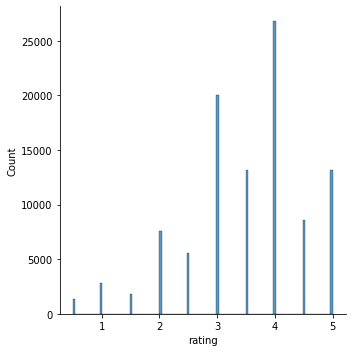

In [23]:
sns.displot(ratings_df['rating'])

## MF 구현

In [24]:
# 학습데이터, 하이퍼파라미터 initialize

# 유저 아이템의 Rating 매트릭스
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)

# numpy 형태로 변환
R = user_item_matrix.to_numpy()

# 잠재 요인의 수
K = 20
learning_rate = 0.01

# l2 정규화 파라미터
regularization = 0.2

# 학습데이터의 반복 횟수
iterations = 20

num_users, num_items = user_item_matrix.shape

In [25]:
# 학습 파라미터 initialize

# 평균이 0, 표준편차는 1/K로 랜덤하게 initialize
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

# Initialize the biases

# 유저별 bias
b_u = np.zeros(num_users)
# 아이템별 bias
b_i = np.zeros(num_items)
# 전체 bias
b = np.mean(R[np.where(R != 0)])

In [26]:
R.shape

(610, 9724)

In [27]:
# 학습 데이터 구성
# 실제 평가를 내린 데이터만 학습에 사용함

samples = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

In [28]:
# 총 학습 데이터 사이즈
len(samples)

100836

- Parameter Update
![ab](https://i.ibb.co/QCgV5Ys/svd-sgd.png)

In [29]:
# SGD를 활용한 파라미터 업데이트

training_result = []

for epoch in range(iterations):
    
    # 학습 데이터 순서를 셔플링
    np.random.shuffle(samples)
    
    for i, j, r in samples:
        
        # 현재 주어진 파라미터로 predicted rating을 구함
        prediction = b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)
        # 실제 rating과 predicted rating의 차이가 error
        e = (r - prediction)

        # 유저, 아이템 bias 파라미터를 업데이트
        b_u[i] += learning_rate * (e - regularization * b_u[i])
        b_i[j] += learning_rate * (e - regularization * b_i[j])

        # 유저, 아이템 잠재 행렬 파라미터를 업데이트
        P[i, :] += learning_rate * (e * Q[j, :] - regularization * P[i,:])
        Q[j, :] += learning_rate * (e * P[i, :] - regularization * Q[j,:])
        
    
    # 학습이 모두 끝나고 학습 데이터를 활용해 training loss를 구합니다
    ut, it = R.nonzero()
    predicted_R = b + b_u[:,np.newaxis] + b_i[np.newaxis:,] + P.dot(Q.T) # add new axis, dimension 1 => 2
    error = []
    for x, y in zip(ut, it):
        error.append(pow(R[x, y] - predicted_R[x, y], 2))
    rmse = np.sqrt(np.asarray(error).mean())
    print(epoch+1, rmse)
    training_result.append([epoch+1, rmse])

training_result_pd = pd.DataFrame(training_result, columns = ['iteration', 'rmse'])

1 0.8977249668388066
2 0.877289760991885
3 0.8660882789355437
4 0.8573171997008906
5 0.8523401303627859
6 0.8471585739036257
7 0.843736732087284
8 0.8403665101689365
9 0.8380879938943965
10 0.8353486447551656
11 0.8329249129566343
12 0.8308144910618454
13 0.8287650040570125
14 0.8275604286148257
15 0.8261207428971503
16 0.8253136057981352
17 0.8240969051288499
18 0.8227636770698904
19 0.8214054773848662
20 0.8203815990761009


## MF Class

In [30]:
import numpy as np

# 위에서 구한 MF를 SGD로 학습하는 것을 class 형태로 만듦

class MF():

    def __init__(self, R, K, learning_rate, regularization, iterations):
        """
        Arguments
        - R (ndarray)             : 유저 아이템 매트릭스
        - K (int)                 : latent factor 차원
        - learning_rate (float)   : learning rate
        - regularization (float)  : regularization parameter
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations

    def train(self):
        
        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # 유저, 아이템, 글로벌 bias 초기화
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # 학습 데이터 생성
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # iteration 개수만큼 전체 데이터에 대해서 SGD 수행
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i, rmse))
            if (i+1) % 10 == 0:
                print("Iteration: %d, error = %.4f" % (i+1, rmse))

        return pd.DataFrame(training_process, columns = ['iteration', 'rmse'])

    def rmse(self):
        """
        전체 학습 데이터에 대한 rmse 계산
        """
        ut, it = self.R.nonzero()
        predicted_R = self.full_matrix()
        error = []
        for x, y in zip(ut, it):
            error.append(pow(R[x, y] - predicted_R[x, y], 2))
        return np.sqrt(np.asarray(error).mean())

    def sgd(self):
        """
        sgd로 파라미터 업데이트가 되는 함수
        """
        for i, j, r in self.samples:
            # 실제 rating과 predicted rating을 구하고 error를 구함
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # bias 업데이트
            self.b_u[i] += self.learning_rate * (e - self.regularization * self.b_u[i])
            self.b_i[j] += self.learning_rate * (e - self.regularization * self.b_i[j])

            # 유저, 아이템 잠재 요인 행렬 업데이트
            self.P[i, :] += self.learning_rate * (e * self.Q[j, :] - self.regularization * self.P[i,:])
            self.Q[j, :] += self.learning_rate * (e * self.P[i, :] - self.regularization * self.Q[j,:])

    def get_rating(self, i, j):
        """
        유저 i, 아이템 j에 대한 예측 평점
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        예측된 유저 아이템 매트릭스를 계산 Rhat
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [31]:
# 주어진 유저-아이템 매트릭스

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

mf = MF(R, K=2, learning_rate=0.1, regularization=0.01, iterations=30)

In [32]:
# MF 모델 학습
train_result_df = mf.train()

Iteration: 10, error = 0.3038
Iteration: 20, error = 0.0630
Iteration: 30, error = 0.0209


In [33]:
# 예측 매트릭스
mf.full_matrix()

array([[4.99535761, 2.98728313, 4.46647038, 1.01671257],
       [3.99170961, 2.22593586, 4.00834371, 1.00750187],
       [1.04106116, 0.97231188, 4.66160257, 4.99560785],
       [0.99902554, 0.69249891, 4.18539502, 3.98986848],
       [1.48540136, 1.04460414, 4.97690674, 3.99824545]])

### 무비렌즈 데이터로 학습

In [34]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)
R = user_item_matrix.to_numpy()
K = 20
learning_rate = 0.01
regularization = 0.2

mf = MF(R, K, learning_rate, regularization, iterations=30)

In [35]:
train_result_df = mf.train()

Iteration: 10, error = 0.8349
Iteration: 20, error = 0.8208
Iteration: 30, error = 0.8128


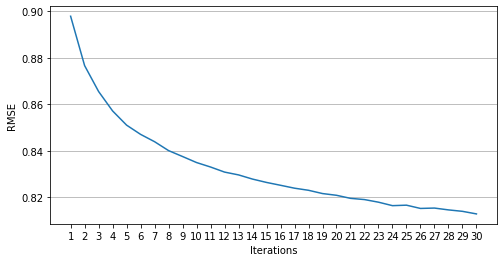

In [36]:
# iteration에 따른 training loss

x = train_result_df.iteration.values + 1
y = train_result_df.rmse.values
plt.figure(figsize=((8,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.grid(axis="y")

# Matrix Factorization의 ALS 구현
1. 초기 아이템, 사용자 행렬을 초기화
2. 아이템 행렬을 고정하고 사용자 행렬을 최적화
3. 사용자 행렬을 고정하고 아이템 행렬을 최적화
4. 위의 2, 3 과정을 반복

## ALS 구현

In [66]:
# 유저-아이템 행렬

R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])


In [67]:
# 학습데이터, 하이퍼파라미터 초기화

# 잠재요인 개수
k = 5

# l2 하이퍼파라미터
regularization = 0.01
num_users, num_items = R.shape

# ALS 업데이트 횟수
iterations = 100

In [68]:
# 유저, 아이템 잠재요인 매트릭스

users = np.random.normal(scale=1./k, size=(num_users, k))
items = np.random.normal(scale=1./k, size=(num_items, k))

In [69]:
items.shape

(5, 5)

- ALS 업데이트 수식
![수식](https://i.ibb.co/Csh6Yb0/2021-06-25-10-50-03.png)

In [70]:
# iteration마다 상위에 있는 수식을 활용해 유저, 아이템을 업데이트 한다
# 참고: https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

training_process = []
for epoch in range(iterations):
    for i, Ri in enumerate(R):
        users[i] = np.linalg.solve(np.dot(items.T, items) + regularization * np.eye(k), \
                                   np.dot(items.T, R[i].T)).T

    for j, Rj in enumerate(R.T):
        items[j] = np.linalg.solve(np.dot(users.T, users) + regularization * np.eye(k), \
                                   np.dot(users.T, R[:, j]))

    cost = 0
    xi, yi = R.nonzero()
    for x, y in zip(xi, yi):
        cost += pow(R[x, y] - users[x, :].dot(items[y, :].T), 2)
        
    cost = np.sqrt(cost/len(xi))
    training_process.append((epoch, cost))
    
    if (epoch + 1) % 10 == 0:
        print("Iteration: %d, cost = %.4f" % (epoch + 1, cost))

Iteration: 10, cost = 0.0008
Iteration: 20, cost = 0.0012
Iteration: 30, cost = 0.0015
Iteration: 40, cost = 0.0017
Iteration: 50, cost = 0.0019
Iteration: 60, cost = 0.0020
Iteration: 70, cost = 0.0022
Iteration: 80, cost = 0.0023
Iteration: 90, cost = 0.0024
Iteration: 100, cost = 0.0025


In [71]:
R

array([[1, 0, 0, 1, 3],
       [2, 0, 3, 1, 1],
       [1, 2, 0, 5, 0],
       [1, 0, 0, 4, 4],
       [2, 1, 5, 4, 0],
       [5, 1, 5, 4, 0],
       [0, 0, 0, 1, 0]])

In [72]:
R_hat = users.dot(items.T)
R_hat

array([[ 9.98899936e-01, -4.68935024e-03, -1.69936228e-04,
         1.00237503e+00,  2.99627767e+00],
       [ 1.99979231e+00, -9.54968039e-04,  2.99814158e+00,
         1.00143674e+00,  9.98355620e-01],
       [ 9.99995924e-01,  1.99519736e+00,  1.97542123e-03,
         4.99838823e+00,  1.05814651e-03],
       [ 1.00070635e+00,  4.55374713e-03,  7.03367968e-04,
         3.99770480e+00,  3.99844759e+00],
       [ 2.00490936e+00,  9.99270556e-01,  4.99619829e+00,
         3.99923656e+00, -4.81487594e-04],
       [ 4.99434245e+00,  1.00151015e+00,  5.00088948e+00,
         3.99981289e+00,  1.55716430e-03],
       [ 3.74624084e-04,  4.14564651e-03,  5.44197239e-04,
         9.97975797e-01,  1.36395405e-03]])

## ALS 클래스

In [73]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

class AlternatingLeastSquares():
    def __init__(self, R, k, regularization, iterations, verbose=False):
        """
        Arguments
        - R (ndarray)             : 유저 아이템 매트릭스
        - k (int)                 : latent factor 차원
        - reg_param (float)       : regularization parameter
        - epochs (int)            : als로 파라미터 업데이트를 수행하는 횟수
        - verbose (boolean)       : 학습 과정의 status print 옵션
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.k = k
        self.regularization = regularization
        self.iterations = iterations
        self.verbose = verbose


    def fit(self):

        # 유저, 아이템 매트릭스를 초기화
        self.users = np.random.normal(scale=1./k, size=(self.num_users, self.k))
        self.items = np.random.normal(scale=1./k, size=(self.num_items, self.k))

        # iteration 개수만큼 ALS를 수행하여 유저, 아이템 파라미터를 업데이트함
        self._training_process = [] 
        for iteration in range(self.iterations):
            for i, Ri in enumerate(self.R):
                self.users[i] = self.user_latent(i, Ri)

            for j, Rj in enumerate(self.R.T):
                self.items[j] = self.item_latent(j, Rj)
            
            # iteration 수행이 끝날때마다 training loss를 계산함
            cost = self.cost()
            self._training_process.append((iteration, cost))

            # 10번째마다 loss를 출력하는 옵션
            if self.verbose == True and ((iteration + 1) % 10 == 0):
                print("Iteration: %d, cost = %.4f" % (iteration + 1, cost))

    def cost(self):
        """
        학습 데이터 전체의 rmse 계산
        """
        xi, yi = self.R.nonzero()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self.R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def user_latent(self, i, Ri):
        """
        유저 i에 대한 유저 벡터 업데이트
        """

        du = np.linalg.solve(np.dot(self.items.T, self.items) + self.regularization * np.eye(self.k),
                                   np.dot(self.items.T, self.R[i].T)).T
        return du

    def item_latent(self, j, Rj):
        """
        아이템 j에 대한 아이템 벡터 업데이트
        """

        di = np.linalg.solve(np.dot(self.users.T, self.users) + self.regularization * np.eye(self.k),
                                 np.dot(self.users.T, self.R[:, j]))
        return di


    def get_prediction(self, i, j):
        """
        유저 i, 아이템 j에 대한 예측 평점
        """
        return self.users[i, :].dot(self.items[j, :].T)


    def get_full_matrix(self):
        """
        예측된 유저 아이템 매트릭스를 계산 Rhat
        """
        return self.users.dot(self.items.T)

In [74]:
R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

als = AlternatingLeastSquares(R = R, regularization = 0.01, iterations=20, verbose=True, k=5)
als.fit()

Iteration: 10, cost = 0.0007
Iteration: 20, cost = 0.0011


In [75]:
als.get_full_matrix()

array([[ 9.99810173e-01, -3.15060496e-03, -3.36330029e-04,
         1.00116368e+00,  2.99825621e+00],
       [ 2.00008552e+00, -8.06943155e-04,  2.99923984e+00,
         1.00065884e+00,  9.99259402e-01],
       [ 9.99966108e-01,  1.99746338e+00,  6.42773492e-04,
         4.99958152e+00, -1.99060656e-05],
       [ 1.00002043e+00,  2.64021302e-03,  3.14222488e-04,
         3.99899358e+00,  4.00009728e+00],
       [ 2.00151268e+00,  9.99434387e-01,  4.99826443e+00,
         3.99994207e+00, -3.45278248e-04],
       [ 4.99848196e+00,  1.00114380e+00,  5.00092012e+00,
         3.99976445e+00,  6.87184413e-04],
       [-2.37056898e-05,  2.63660781e-03,  3.96652271e-04,
         9.99033353e-01,  9.51391694e-04]])

In [76]:
als.get_prediction(1, 3)

1.0006588372403666

# Surprise에서 제공하는 MF 모델 (SVD)
- 지난 시간에 사용한 Surprsie 패키지에서 추천 모델을 제공한다.
    - Surprise의 SVD는 SGD로 학습되는 MF를 의미한다.
- SGD로 모델이 학습될 때 변경 가능한 옵션과 하이퍼파라미터에 대해서 살펴본다.
- 무비렌즈 데이터를 활용해 KNN 모델과 SVD모델을 각각 학습해보고 추천 성능을 비교해보자.

In [77]:
# surprise에서 제공하는 dataset과 reader

from surprise import Reader, Dataset

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [78]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

## SVD Model

- [모델 API 문서](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
- The SVD++ algorithm, an extension of SVD taking into account implicit ratings.

In [79]:
# SVD 모델을 사용하자 => MF의 SGD 구현을 Suprise에서 SVD로 부름

svd_model = SVD(n_factors=20, reg_all = 0.02)

# 학습데이터를 가지고 모델 학습
svd_model.fit(train_data)

# 테스트 데이터로 모델의 예측 평점을 추론
predictions = svd_model.test(test_data)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8668


0.8668081311916622

In [80]:
# 유저/아이템 매트릭스

print(svd_model.pu.shape)
print(svd_model.qi.shape)

(610, 20)
(8933, 20)


In [81]:
# 유저 0의 latent factor

svd_model.pu[0]

array([ 0.07380621, -0.06692793, -0.01942939, -0.14955216,  0.01818387,
       -0.10913621,  0.15902081, -0.17509367,  0.13926057,  0.01303776,
        0.04174939, -0.0018524 ,  0.04205402,  0.0839531 , -0.35875277,
       -0.20206477, -0.02747232, -0.13191464, -0.13195688,  0.02076674])

In [82]:
# 아이템 0의 latent factor

svd_model.qi[0]

array([-0.03139309,  0.15404227,  0.11104108,  0.14684663, -0.06158748,
       -0.0228011 , -0.25756611,  0.20263045,  0.25347548,  0.01855477,
        0.01215266, -0.19974691,  0.28118865,  0.13565833,  0.13103271,
        0.12963981,  0.25759053,  0.05920032, -0.11346777,  0.01587297])

In [83]:
# 평점 예측

user_id = 1
item_id = 1

svd_model.predict(user_id, item_id)

Prediction(uid=1, iid=1, r_ui=None, est=4.6288738687233515, details={'was_impossible': False})

In [84]:
# 새로운 유저, 아이템이 등장할 경우 default_prediction를 사용

user_id = 0
item_id = 0

print(svd_model.predict(user_id, item_id).est)
print(svd_model.default_prediction())

3.5001859473397134
3.5001859473397134


![default_prediction](https://i.ibb.co/6YxrX1s/default-prediction.png)

### [모델 상세 옵션](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

- Rating Function
![ab](https://i.ibb.co/MSZJKLp/svd-rating.png)
- Objective Function
![ab](https://i.ibb.co/DzMmtyx/svd-obj.png)

In [85]:
# bias 유무에 따른 성능 비교

for biased in [False, True]:
    svd_model = SVD(biased=biased)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('biased:', biased, ',', accuracy.rmse(predictions))


RMSE: 0.9868
biased: False , 0.9868480466455576
RMSE: 0.8717
biased: True , 0.8717097729884191


In [86]:
# latent factor 수에 따른 성능 비교

for k in [25, 50, 100, 150]:
    svd_model = SVD(n_factors=k)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('n_factors:', k, ',', accuracy.rmse(predictions))


RMSE: 0.8680
n_factors: 25 , 0.8680233997092965
RMSE: 0.8688
n_factors: 50 , 0.8688039750179892
RMSE: 0.8694
n_factors: 100 , 0.8694304155282296
RMSE: 0.8717
n_factors: 150 , 0.8717075522153843


In [87]:
# learning rate에 따른 성능 비교

for lr_all in [.0025, .005, .001]:
    svd_model = SVD(lr_all=lr_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('lr_all:', lr_all, ',', accuracy.rmse(predictions))


RMSE: 0.8791
lr_all: 0.0025 , 0.8791246241187973
RMSE: 0.8684
lr_all: 0.005 , 0.8684393236369308
RMSE: 0.8944
lr_all: 0.001 , 0.8943944920696499


In [88]:
# regularization에 따른 성능 비교

for reg_all in [0, 0.02, 0.1, 1]:
    svd_model = SVD(reg_all=reg_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('reg_all:', reg_all, ',', accuracy.rmse(predictions))


RMSE: 0.8922
reg_all: 0 , 0.8922486959885384
RMSE: 0.8706
reg_all: 0.02 , 0.8706042912906077
RMSE: 0.8684
reg_all: 0.1 , 0.8683782621427854
RMSE: 0.9051
reg_all: 1 , 0.9051061242525684


In [89]:
# Grid Search 패키지를 제공함

from surprise.model_selection import GridSearchCV

grid = {'lr_all': [.0025, .005], 
        'n_factors': [25, 50, 100],
        'reg_all': [0.02, 0.1]
       }

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=2)
gs.fit(data)

In [97]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse')

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_lr_all,param_n_factors,param_reg_all
7,0.885123,0.878457,0.881790,0.003333,1,1.259836,0.057024,0.360754,0.003416,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.10
9,0.885297,0.878478,0.881887,0.003409,2,1.448279,0.003696,0.374078,0.001275,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.10
6,0.887012,0.878884,0.882948,0.004064,3,1.272384,0.005376,0.431445,0.042519,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.02
11,0.886583,0.879570,0.883077,0.003506,4,2.726787,0.173621,0.418329,0.010730,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.10
8,0.889431,0.881482,0.885456,0.003975,5,1.408219,0.023825,0.287977,0.056975,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.02
10,0.892716,0.886476,0.889596,0.003120,6,2.667909,0.018121,0.354392,0.042899,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.02
0,0.893326,0.887204,0.890265,0.003061,7,1.182749,0.003514,0.384532,0.025060,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.02
1,0.893540,0.887066,0.890303,0.003237,8,1.166492,0.020855,0.317419,0.067497,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.10
3,0.894352,0.887641,0.890996,0.003355,9,1.521773,0.113391,0.302504,0.078223,"{'lr_all': 0.0025, 'n_factors': 50, 'reg_all':...",0.0025,50,0.10
2,0.894874,0.888104,0.891489,0.003385,10,1.530586,0.010665,0.361283,0.001688,"{'lr_all': 0.0025, 'n_factors': 50, 'reg_all':...",0.0025,50,0.02


In [91]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8817898424848083}
{'rmse': {'lr_all': 0.005, 'n_factors': 25, 'reg_all': 0.1}}


## 예측 모델 간의 성능 비교

- 지난시간에 배운 KNN과 MF(SVD) 사이의 모델 성능을 비교해보자

In [92]:
# KNN 모델

sim_options = {
    'name': 'msd',
    'user_based': False
}

knn = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8959  0.8948  0.8840  0.8885  0.8961  0.8919  0.0048  
MAE (testset)     0.6846  0.6840  0.6774  0.6787  0.6838  0.6817  0.0030  
Fit time          4.25    4.05    3.89    3.84    3.70    3.95    0.19    
Test time         7.67    7.38    6.67    6.73    7.14    7.12    0.38    


{'test_rmse': array([0.89588592, 0.8947679 , 0.88400366, 0.88846784, 0.8961274 ]),
 'test_mae': array([0.68456817, 0.68403841, 0.67738954, 0.67870204, 0.6837754 ]),
 'fit_time': (4.254040956497192,
  4.049951791763306,
  3.8850748538970947,
  3.842864990234375,
  3.70485782623291),
 'test_time': (7.672054767608643,
  7.3797829151153564,
  6.670558929443359,
  6.7324559688568115,
  7.135619163513184)}

In [93]:
# SVD 모델

svd = SVD(n_factors=25, lr_all=0.005, reg_all=0.1)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8707  0.8728  0.8757  0.8682  0.8676  0.8710  0.0030  
MAE (testset)     0.6700  0.6698  0.6743  0.6696  0.6687  0.6705  0.0020  
Fit time          1.87    1.89    1.89    1.87    1.88    1.88    0.01    
Test time         0.20    0.09    0.20    0.10    0.19    0.16    0.05    


{'test_rmse': array([0.87070924, 0.87284774, 0.87565554, 0.86817313, 0.86758787]),
 'test_mae': array([0.67003361, 0.66977008, 0.67430051, 0.66963418, 0.66865309]),
 'fit_time': (1.8651511669158936,
  1.8866848945617676,
  1.8852827548980713,
  1.8725008964538574,
  1.8761088848114014),
 'test_time': (0.20186495780944824,
  0.09291481971740723,
  0.19897103309631348,
  0.09630608558654785,
  0.19020986557006836)}